# Deep Learning for Predictive Maintenance

This is the skeleton code file for the EE4802/IE4213 assignment. Replace the XX in the name of this Colab notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Colab notebook section by section). At the end, the entire Colab notebook should generate all the required results and execute without error.

The text above the blank cells provide some information on the functionality that needs to be implemented. You need to write Python code at places indicated by "[WriteCode]".

In this notebook, we explore the following:

1. CNN 1D and LSTM models
2. Two types of prediction tasks
  
  a. Binary Classification :  determining if a machine will fail in a given "w1" window period (Yes/No)

  b. Regression : predicting the remaining time a machine can run before failing (RUL)


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras # make sure you use TensorFlow Keras
import seaborn as sns
import warnings
import os
import time
%matplotlib inline

from sklearn import preprocessing

# Extra imports must be done by students
from sklearn.preprocessing import MinMaxScaler

# Setting seed for reproducibility (uncomment and use if needed)
np.random.seed(9)  
PYTHONHASHSEED = 0

## Setting up TensorBoard

In [2]:
def get_run_logdir(k):
  root_logdir = os.path.join(os.curdir, "ee4802_logs", k)
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

## Initialize model parameters

Use the form below to enter parameter values before re-running the Colab notebook. 

Use the same no. of epochs (ep) and batch size (ba) values for all the baseline CNN-Bin, LSTM-Bin, CNN-RUL and LSTM-RUL models.

Create additional variables and fields in this form as you require.

In [3]:
#@title Input Parameters { run: "auto", form-width: "50%" }
sequence_length = 25#@param {type:"number"} # length of each sequence of values
ep =  5#@param {type:"number"} # epochs
ba =  100#@param {type:"number"} # batch_size                 

In [4]:
# DO NOT CHANGE the settings in this cell
w1 = 30 # window size before failure classification

## Data Ingestion
In the following section, 
- We ingest the training, test and ground truth datasets
- We provide column headings for consistency

(*Note*: training, test and ground truth dataframes are named "train_df", "test_df", and "truth_df" correspondingly. This naming is used consistently throughout the skeleton file.)

In [5]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# final Training data
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

--2022-04-13 11:57:20--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.3’

PM_train.txt.3      100%[===================>]   3.35M  --.-KB/s    in 0.08s   

2022-04-13 11:57:20 (39.4 MB/s) - ‘PM_train.txt.3’ saved [3515356/3515356]

--2022-04-13 11:57:20--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.3’

PM_te

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Exploration

Understanding the underlying characteristics of the dataset:
- Plot cross-correlation heatmap to understand correlation between sensor readings in training data (use seaborn package)
- Observe the data characteristics of three machines with shortest, average and longest operating lifetime (code provided)

(*Note*: use the results to answer the Data Exploration question Section 7 of the assignment document)

### Cross-correlation Heatmap

Expected result:

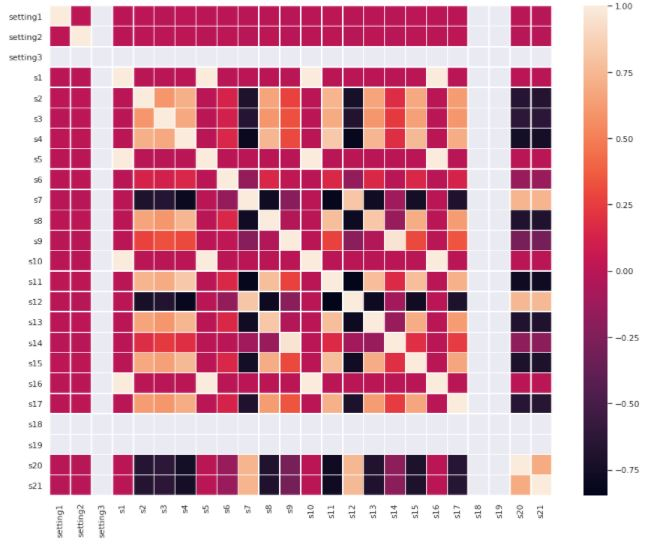

In [6]:
# Cross-correlation HeatMap

sns.set() 
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

df_sub = train_df.copy()
del df_sub['id']

df_sub.set_index('cycle', inplace=True)

# [WriteCode] to determine Pearson correlation and save in dataframe df_corr
# [WriteCode] for plotting cross-correlation heatmap using seaborn

### Shortest, Average and Longest machine lifetimes

In [7]:
# Some Plotting Functions

mapp = {}
for id_num in train_df['id'].unique():
    mapp[id_num] = train_df['cycle'].loc[train_df['id'] == id_num].max()
mapp_len = sorted(mapp.items(), key=lambda kv: kv[1])
wind_size = w1

def exclude_trivial(df_sub):
    cols = []
    for col in df_sub.columns:
        if col == 'id':
            continue
        elif col == 'RUL':
            continue
        elif len(df_sub[col].unique()) <= 2:
            continue
        else:
            cols.append(col)
    return df_sub[cols].copy()

def get_data_non_trivial(df, unit_num, ):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = exclude_trivial(df_sub)
    return df_sub

def get_data_by_cols_and_unit(df, unit_num, cols):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = df_sub[cols]
    return df_sub

def plot_ts(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))
    for col, ax in zip(cols, axes):
        df_sub[col].plot(ax = ax)
        df_sub[col].rolling(wind_size).median().plot(ax = ax)
        df_sub[col].rolling(wind_size).mean().plot(style = '--', legend=True, ax = ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))

def plot_hist(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(df_sub[[col]], ax=ax, label=col)
        labels(col, "p", ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))
    
def plot_learn(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.ylim((0, 0.1))
    plt.xlim((1, ep))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

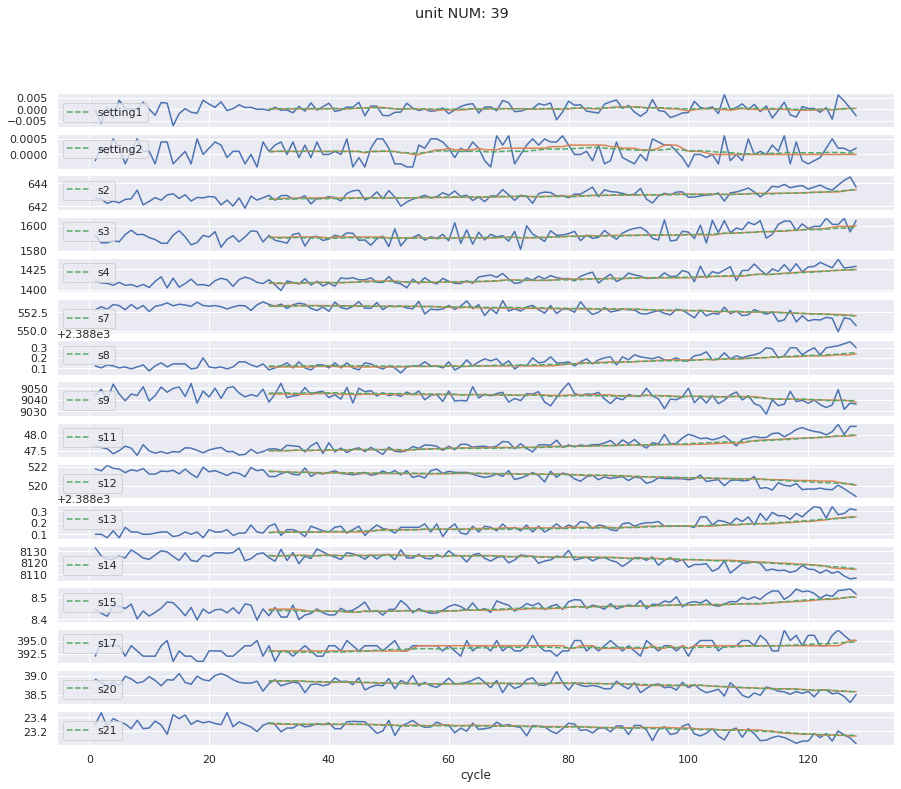

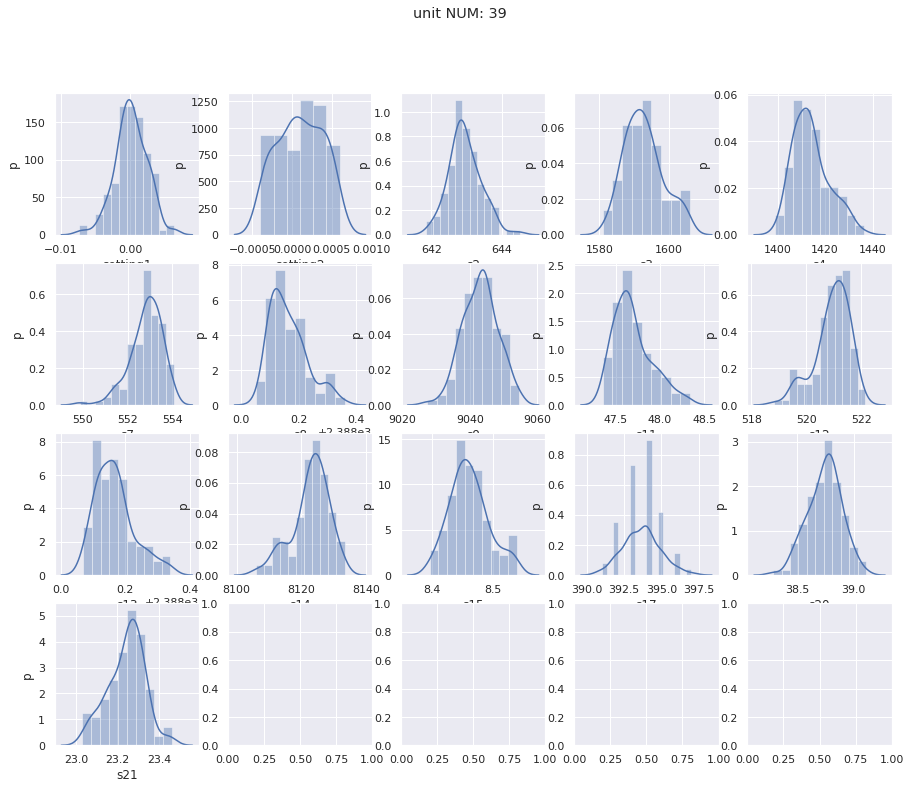

In [8]:
# Plotting sensor readings and distribution of sensor readings for machines with shortest, medium and longest operating times
warnings.filterwarnings('ignore')

# plot shortest operating time machine data
unit_to_plt = mapp_len[0][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

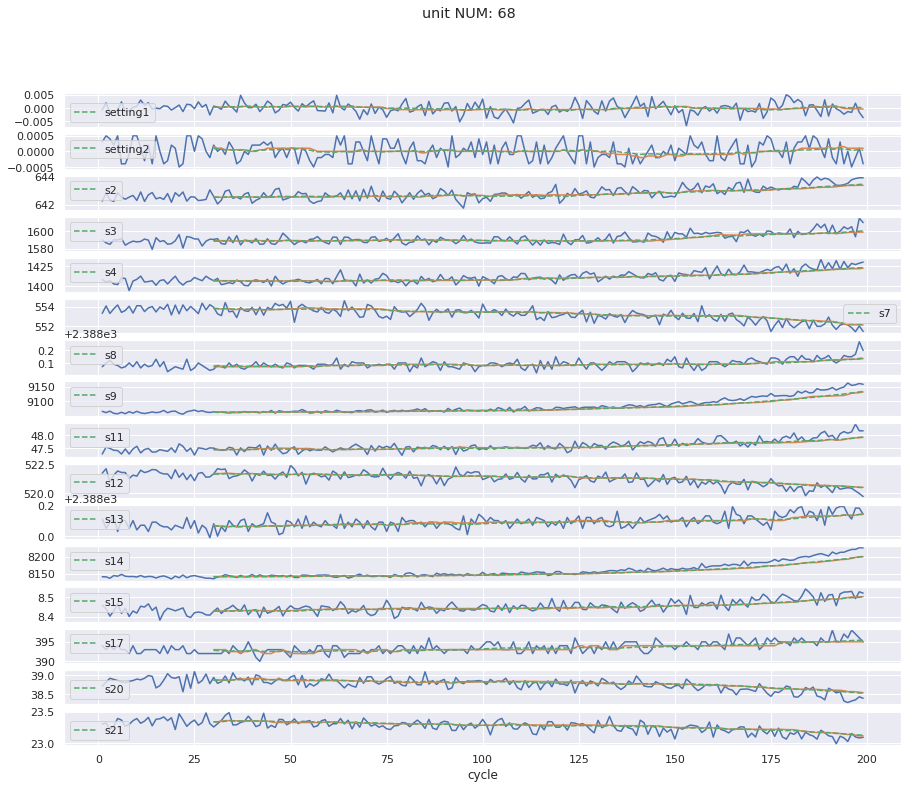

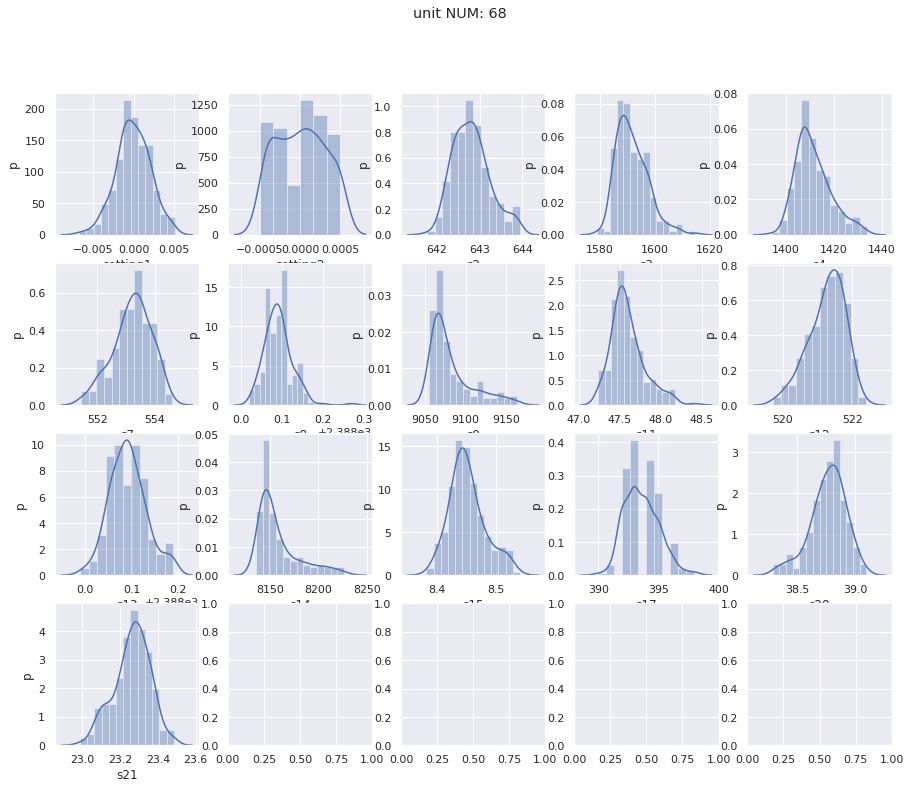

In [9]:
# plot medium operating time machine data
unit_to_plt = mapp_len[int(len(mapp)/2)][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

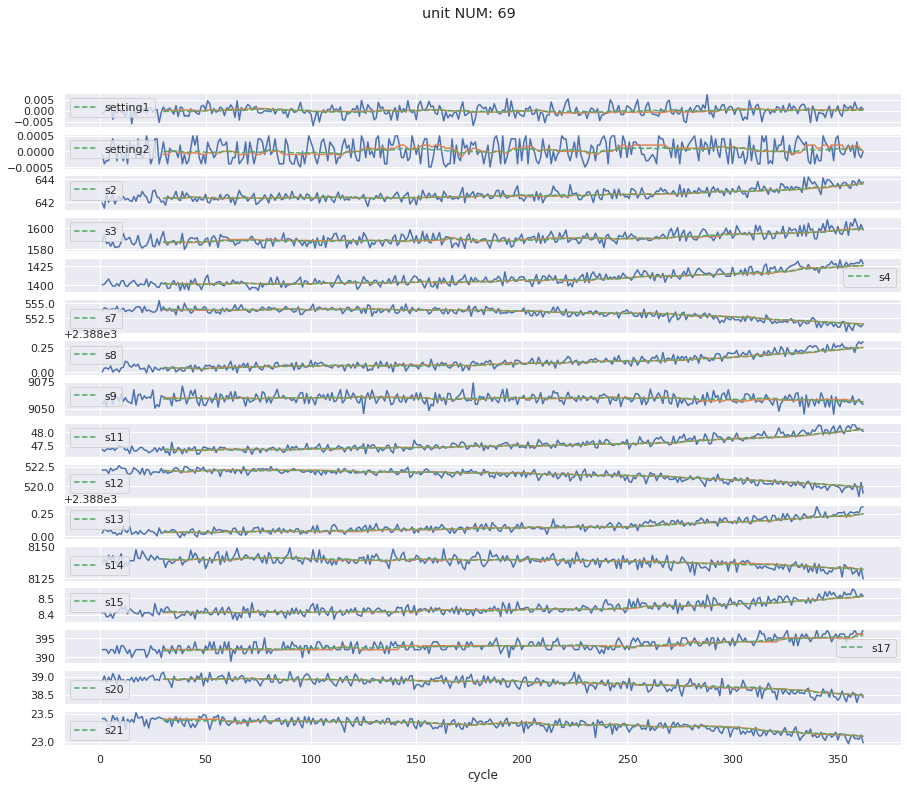

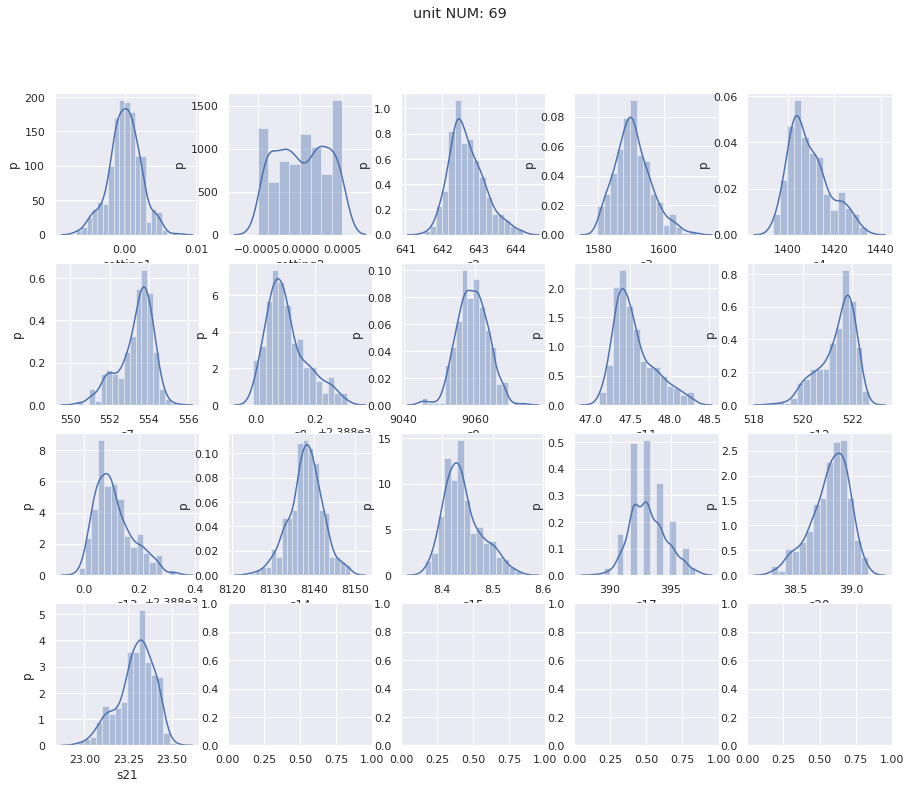

In [10]:
# plot longest operating time machine data
unit_to_plt = mapp_len[-1][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

warnings.filterwarnings('default')

## Data Preprocessing


### Data Labeling

Generating labels for the training data for both prediction tasks:
- Remaining Useful Life ("RUL") for regression task
- "label1" for binary classification (to answer the question: is a specific engine going to fail within "w1" cycles?)

Columns "RUL" and "label1" are created

(*Note*: Column names are case-sensitive and this section is already coded.)

In [11]:
# Data Labeling for training data - generate column RUL

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label1 column for training data
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [12]:
# Data Labeling for test data - generate column RUL

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label1 column for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


### Data Normalization

Perform minmax normalization using MinMax scaler in sklearn on both training and test data (train_df and test_df)


In [13]:
# MinMax normalization for training data

train_df['cycle_norm'] = train_df['cycle']

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
train_df.iloc[:,2:-2] = scaler.fit_transform(train_df.iloc[:,2:-2].to_numpy())
train_df['cycle_norm'] = scaler2.fit_transform(train_df['cycle_norm'].to_numpy().reshape(-1, 1))
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,0.529086,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,0.526316,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,0.523546,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,0.520776,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,0.518006,0,0.01108


In [14]:
# MinMax normalization for test data

test_df['cycle_norm'] = test_df['cycle']

test_df.iloc[:,2:-2] = scaler.transform(test_df.iloc[:,2:-2].to_numpy())
test_df['cycle_norm'] = scaler2.transform(test_df['cycle_norm'].to_numpy().reshape(-1, 1))
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.393352,0,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.390582,0,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.387812,0,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.385042,0,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.382271,0,0.01108


### Data Plotting

In this section, students must plot training data. Please do the follwing:
- Use only data pertaining to engine id = 3
- Plot only the last "sequence_length" operating cycles for each sensor reading in engine 3 training data (for example: if seq_len = 50, plot the last 50 operating cycles of engine 3). 
- Use separate plot for each column or sensor reading. 

X axis: cycles and Y axis : sensor reading

expected result:
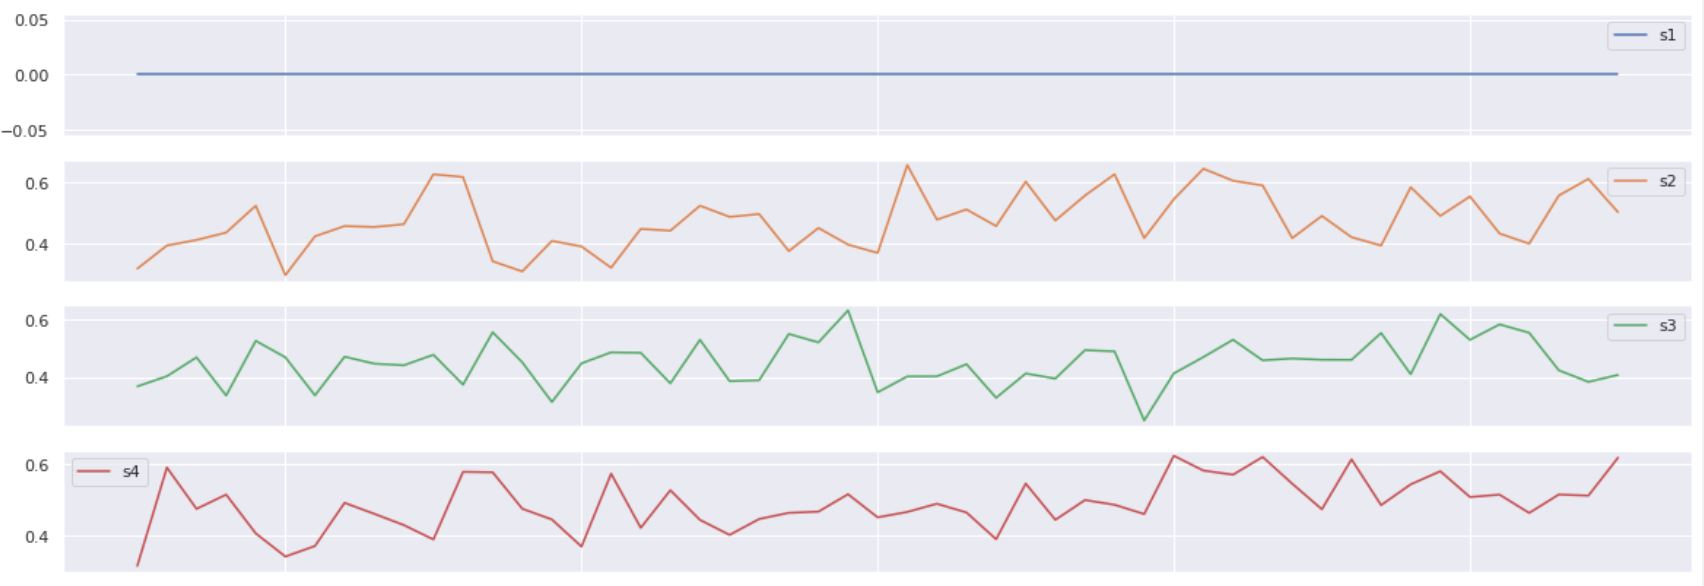

In [15]:
# [WriteCode]

### Data Sequence Generation

Any deep learning model requires two data arrays for model training. The first array is the input sequence array X (named "**seq_array**" in this skeleton file) which contains the input features. The second array is the desired target array Y (named "**label_array**" in this skeleton file) which contains the actual output or ground truth. This target output "label_array" is different for binary classification and RUL regression.

In addition, Keras layers expect the input "seq_array" in the shape of a numpy array of 3 dimensions (no. of samples, time steps, features) where no. of samples is the number of training sequences, time steps is the look back window of sequence length and features is the number of features of each sequence at each time step. 

In this section, train_df is used to generate seq_array. Label_array generation is done separately for each prediction task.

In [16]:
# function to reshape features into seq_array: (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the training sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# final seq_array which is X input to CNN/LSTM
print(seq_array.shape)

(18131, 25, 25)


## Failure Classification

### Label array generation


In [17]:
# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "label1" col as its binary classification)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output for CNN and LSTM 
print(label_array.shape)

(18131, 1)


### CNN Model
In this section, build a 1D CNN network to do binary classification. The choice of network architecture - no. of layers, type of layers (1D CNN, maxpooling etc.), nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_cnn_bin"
- dropout layer after each CNN layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.


In [18]:
# [WriteCode]

#### Model Training

Fit the model using **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin" for visualization.

In [19]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: user 0 ns, sys: 370 µs, total: 370 µs
Wall time: 379 µs


#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

In [20]:
# [WriteCode]

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [21]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [22]:
# [WriteCode]

#### Hyperparameter Tuning

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model (named "model_cnn_bin_alt").
- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [23]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: user 114 µs, sys: 3 µs, total: 117 µs
Wall time: 155 µs


### LSTM Network
In this section build a LSTM network to do binary classification. The choice of network architecture - no. of layers, type of layers, nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_lstm_bin"
- dropout layer after each LSTM layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.



In [24]:
model_lstm_bin = keras.Sequential(
    [
        # Add a LSTM layer with 100 internal units.
        keras.layers.LSTM(100, input_shape=(seq_array.shape[1], seq_array.shape[2]), return_sequences=True),
        keras.layers.Dropout(0.2),
        # Add a LSTM layer with 50 internal units.
        keras.layers.LSTM(50),
        keras.layers.Dropout(0.2),
        # Add a Dense layer with 1 unit.
        keras.layers.Dense(label_array.shape[1], activation='sigmoid'),
    ]
)

model_lstm_bin.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model_lstm_bin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 25, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin" for visualization.

In [25]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

model_lstm_bin.fit(seq_array, label_array, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=cb)

Epoch 1/5
173/173 [==============================] - 9s 25ms/step - loss: 0.1845 - accuracy: 0.9232 - val_loss: 0.1627 - val_accuracy: 0.9416
Epoch 2/5
173/173 [==============================] - 3s 20ms/step - loss: 0.1071 - accuracy: 0.9566 - val_loss: 0.0701 - val_accuracy: 0.9658
Epoch 3/5
173/173 [==============================] - 3s 19ms/step - loss: 0.0831 - accuracy: 0.9650 - val_loss: 0.0711 - val_accuracy: 0.9603
Epoch 4/5
173/173 [==============================] - 3s 20ms/step - loss: 0.0785 - accuracy: 0.9687 - val_loss: 0.1227 - val_accuracy: 0.9559
Epoch 5/5
173/173 [==============================] - 3s 20ms/step - loss: 0.0767 - accuracy: 0.9691 - val_loss: 0.0724 - val_accuracy: 0.9691
CPU times: user 21.3 s, sys: 1.4 s, total: 22.7 s
Wall time: 24.3 s


#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

In [26]:
print(model_lstm_bin.evaluate(seq_array, label_array)[1])

567/567 [==============================] - 4s 7ms/step - loss: 0.0662 - accuracy: 0.9749
0.9749048352241516


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [27]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [28]:
print(model_lstm_bin.evaluate(seq_array_test_last, label_array_test_last)[1])

4/4 [==============================] - 0s 8ms/step - loss: 0.0868 - accuracy: 0.9600
0.9599999785423279


#### Hyperparameter Tuning

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model (named "model_lstm_bin_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [29]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: user 72 µs, sys: 3 µs, total: 75 µs
Wall time: 80.3 µs


### Comparing CNN 1D and LSTM models for binary classification

Using a Pandas dataframe, combine the results obtained for binary classification such as accuracy, precision, recall and F1 score for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for binary classification.

Display this dataframe.

In [30]:
# [WriteCode]

## RUL Regression

### Label array generation


In [31]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "RUL" col as it's RUL regression)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output to CNN/LSTM
print(label_array.shape)

(18131, 1)


### CNN Model

In this section, build a 1D CNN network to do RUL regression. Use the **same** CNN network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_cnn_rul"
- use the **same** parameter values as the baseline CNN network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [32]:
# [WriteCode]

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul" for visualization.

In [33]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: user 166 µs, sys: 0 ns, total: 166 µs
Wall time: 204 µs


#### Training data performance metrics

- Print the "mean absolute error" metric for training data prediction.

In [34]:
# [WriteCode]

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [35]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [36]:
# [WriteCode]

#### Hyperparameter Tuning

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model for RUL regression (named "model_cnn_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [37]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: user 93 µs, sys: 4 µs, total: 97 µs
Wall time: 103 µs


### LSTM Network

In this section, build a LSTM network to do RUL regression. Use the **same** LSTM network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_lstm_rul"
- use the **same** parameter values as the baseline LSTM network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [38]:
model_lstm_rul = keras.Sequential(
    [
        # Add a LSTM layer with 100 internal units.
        keras.layers.LSTM(100, input_shape=(seq_array.shape[1], seq_array.shape[2]), return_sequences=True),
        keras.layers.Dropout(0.2),
        # Add a LSTM layer with 50 internal units.
        keras.layers.LSTM(50),
        keras.layers.Dropout(0.2),
        # Add a Dense layer with 1 unit.
        keras.layers.Dense(label_array.shape[1]),
    ]
)

model_lstm_rul.compile(
    optimizer="adam",
    loss="mae",
    metrics=["mean_absolute_error"],
)

model_lstm_rul.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 100)           50400     
                                                                 
 dropout_2 (Dropout)         (None, 25, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul" for visualization.

In [39]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')

model_lstm_rul.fit(seq_array, label_array, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=cb)

Epoch 1/5
173/173 [==============================] - 8s 24ms/step - loss: 0.0904 - mean_absolute_error: 0.0904 - val_loss: 0.1083 - val_mean_absolute_error: 0.1083
Epoch 2/5
173/173 [==============================] - 3s 19ms/step - loss: 0.0736 - mean_absolute_error: 0.0736 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867
Epoch 3/5
173/173 [==============================] - 3s 20ms/step - loss: 0.0710 - mean_absolute_error: 0.0710 - val_loss: 0.0766 - val_mean_absolute_error: 0.0766
Epoch 4/5
173/173 [==============================] - 3s 19ms/step - loss: 0.0674 - mean_absolute_error: 0.0674 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 5/5
173/173 [==============================] - 3s 19ms/step - loss: 0.0639 - mean_absolute_error: 0.0639 - val_loss: 0.0643 - val_mean_absolute_error: 0.0643
CPU times: user 20 s, sys: 1.19 s, total: 21.2 s
Wall time: 24 s


#### Training data performance metrics
- Print the "mean absolute error" metric for training data prediction.

In [40]:
print(model_lstm_rul.evaluate(seq_array, label_array)[1])

567/567 [==============================] - 4s 7ms/step - loss: 0.0579 - mean_absolute_error: 0.0579
0.057898133993148804


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [41]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [42]:
print(model_lstm_rul.evaluate(seq_array_test_last, label_array_test_last)[1])

4/4 [==============================] - 0s 8ms/step - loss: 0.0398 - mean_absolute_error: 0.0398
0.03982724994421005


#### Hyperparameter Tuning

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model for RUL regression (named "model_lstm_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [43]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

model_lstm_rul_alt = keras.Sequential(
    [
        # Add a LSTM layer with 100 internal units.
        keras.layers.LSTM(100, input_shape=(seq_array.shape[1], seq_array.shape[2]), return_sequences=True),
        keras.layers.Dropout(0.5),
        # Add a LSTM layer with 50 internal units.
        keras.layers.LSTM(50),
        keras.layers.Dropout(0.5),
        # Add a Dense layer with 1 unit.
        keras.layers.Dense(label_array.shape[1]),
    ]
)

model_lstm_rul_alt.compile(
    optimizer=keras.optimizers.Adam(amsgrad=True),
    loss="mae",
    metrics=["mean_absolute_error"],
)

model_lstm_rul_alt.summary()

model_lstm_rul_alt.fit(seq_array, label_array, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=cb)

print(model_lstm_rul_alt.evaluate(seq_array, label_array)[1])
print(model_lstm_rul_alt.evaluate(seq_array_test_last, label_array_test_last)[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 25, 100)           50400     
                                                                 
 dropout_4 (Dropout)         (None, 25, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
173/173 [==============================]

### Comparing CNN 1D and LSTM models for RUL Regression
Using a Pandas dataframe, combine the results obtained for RUL regression such as MAE for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for RUL regression.

Display this dataframe.

In [44]:
# [WriteCode]

## Visualization with TensorBoard

Many quantities such as loss function and performance metrics are saved while training the models and can be visualized using TensorBoard.

Use these visualizations to provide the evidence in your answers to the questions in Section 7.1 of the assignment document.

Make sure you select the correct information to visualize and compare. 

*Note*: Results from different runs are saved in separate time-stamped folders. 

In [45]:
%load_ext tensorboard
%tensorboard --logdir=./ee4802_logs --port=6006

Reusing TensorBoard on port 6006 (pid 257), started 0:19:45 ago. (Use '!kill 257' to kill it.)

<IPython.core.display.Javascript object>